In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from root_pandas import read_root

%cd '/home/naodell/work/z_plus_jpsi'
#%connect_info

Using TensorFlow backend.


Welcome to JupyROOT 6.11/01
/home/naodell/work/z_plus_jpsi


In [2]:
# get the data
feature_names = [
                 'pt', 'eta', 'phi', 'ptErr',
                 #'trkIso', 'ecalIso', 'hcalIso',
                 'chHadIso', 'gammaIso', 'neuHadIso', 'puIso',
                 #'puppiChHadIso', 'puppiGammaIso', 'puppiNeuHadIso',
                 #'puppiChHadIsoNoLep', 'puppiGammaIsoNoLep', 'puppiNeuHadIsoNoLep',
                 'd0', 'dz', 'sip3d',
                 'tkNchi2', 'muNchi2', 'trkKink', 'glbKink',
                 'trkHitFrac', 'chi2LocPos', 'segComp', 'caloComp',
                 #'q',
                 'nValidHits', 'nTkHits', 'nPixHits', 'nTkLayers', 'nPixLayers', 'nMatchStn',
                 #'typeBits', 'selectorBits', 'pogIDBits', # this will need to be decoded into onehots
                ]

target_names = [
                'genPt', 'genEta', 'genPhi', 
                'genMatched',
                ]
cuts = '3. < pt < 30. \
        and abs(d0) < 0.5 and abs(dz) < 1.0 and abs(sip3d) < 100. \
        and 0. < muNchi2 < 10. and 0. < tkNchi2 < 200. \
        and trkKink < 999. and glbKink < 500000. \
        and chi2LocPos < 2000.'

In [17]:
# get the dataframes (this will take a long time)
input_trees = ['ttbar']
df_test = 0
for df in read_root('data/output_ttbar.root', key='muons_tree_ttbar_semilep', chunksize=10000000):
    df = df[feature_names + target_names].query(cuts)
    neutral_iso = df.gammaIso + df.neuHadIso - 0.5*df.puIso
    neutral_iso[neutral_iso < 0.] = 0.
    
    # add combined pf isolation for comparison to official recommendation
    df['pf_combined'] = (df.chHadIso + neutral_iso) / df.pt
    
    # take the absolute value of variables that are symmetric
    df['eta'] = np.abs(df['eta'])
    df['d0'] = np.abs(df['d0'])
    df['dz'] = np.abs(df['dz'])
    df['sip3d'] = np.abs(df['sip3d'])
    
    df_test = df
    break

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


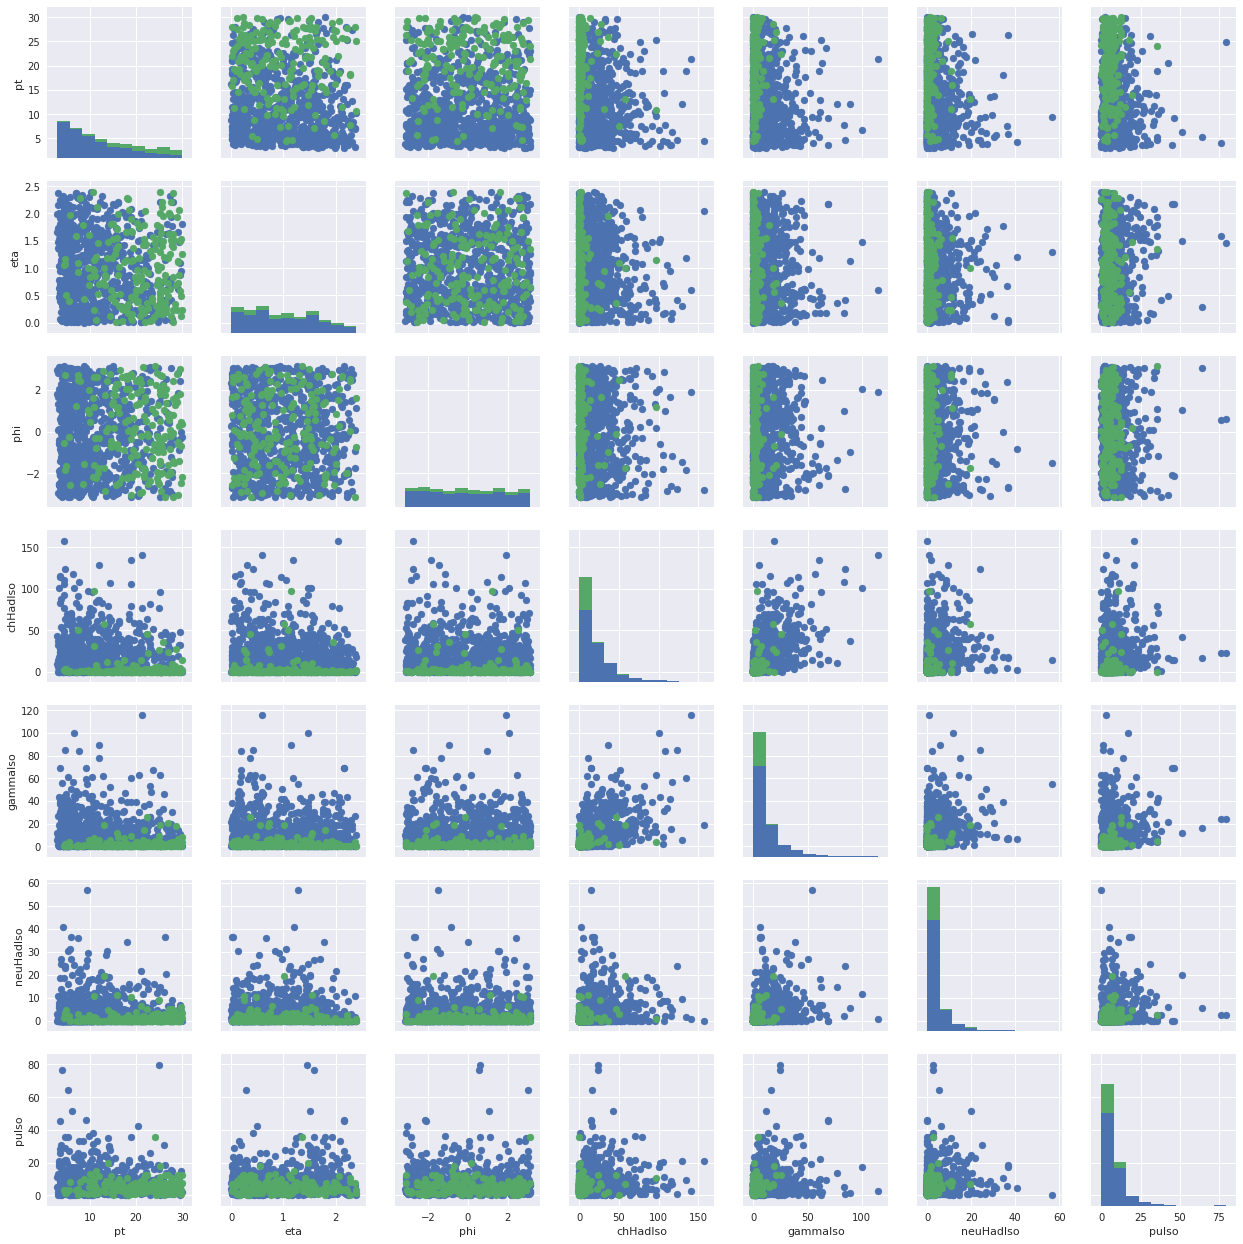

In [4]:
# make some plots
trunc_features = ['pt', 'eta', 'phi', 'chHadIso', 'gammaIso', 'neuHadIso', 'puIso']
df = df_test[:1000][trunc_features + ['genMatched']]

g = sns.PairGrid(df, vars=trunc_features, hue='genMatched')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.show()

In [16]:
# data preprocessing
features = df_test[feature_names].values
targets  = df_test['genMatched'].values

# scale features; convert type bits to one hots
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
mm_scaler = preprocessing.MinMaxScaler()
features  = mm_scaler.fit_transform(features)

df_scaled = pd.DataFrame(features, columns=feature_names)
df_scaled['genMatched'] = targets

# randomize data; split into testing and training sets
ix = np.arange(features.shape[0])
np.random.shuffle(ix)
ix_split = int(0.8*ix.size)
x_train = features[ix,][:ix_split]
x_test  = features[ix,][ix_split:]
y_train = targets[ix] #to_categorical(targets[ix])
y_test  = y_train[ix_split:]
y_train = y_train[:ix_split]

NameError: name 'scaled' is not defined

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


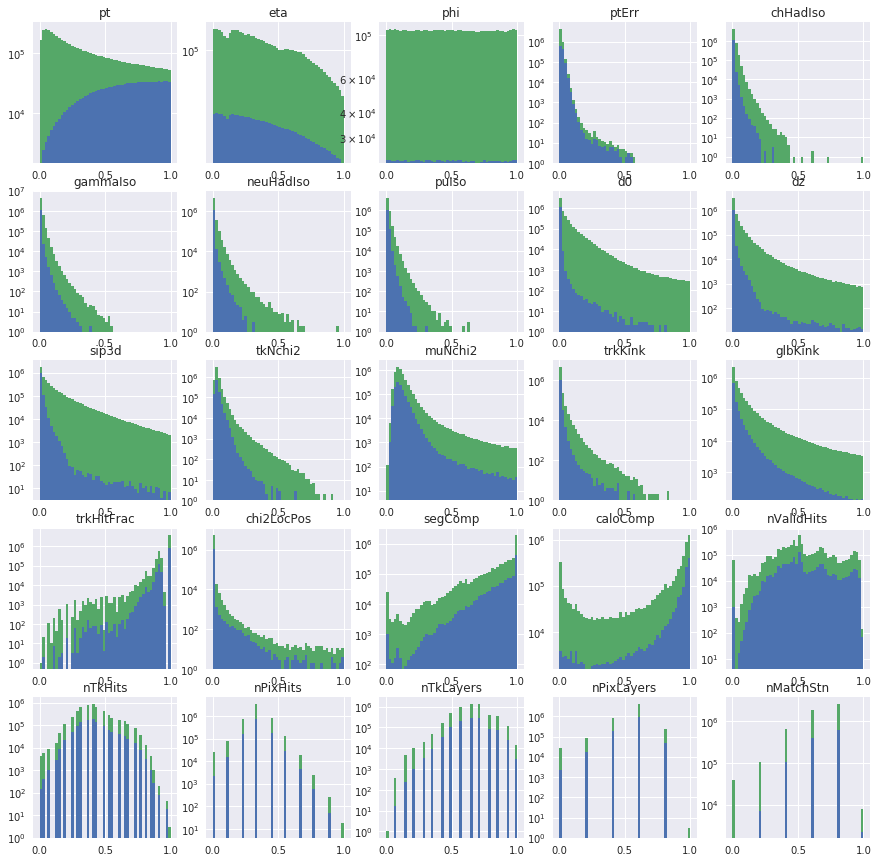

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, feature in enumerate(feature_names):
    a_true = df_scaled[df_scaled['genMatched']][feature]
    a_fake = df_scaled[~df_scaled['genMatched']][feature]
    axes[int(i/5)][i%5].hist([a_true, a_fake], bins=50, stacked=True, color=['C0', 'C1'])
    axes[int(i/5)][i%5].set_title(feature)
    axes[int(i/5)][i%5].set_yscale('log')
plt.show()

In [7]:
# define the network architecture 
model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
model.add(Dense(128, activation='relu', input_dim=features.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels.size, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['binary_accuracy'])

In [8]:
# train the model
model.fit(x_train, y_train,
          epochs = 20,
          batch_size = 128,
          validation_split = 0.1)
#score = model.evaluate(x_test, y_test, batch_size=128)

Train on 3787780 samples, validate on 420865 samples
Epoch 1/20
3787780/3787780 [==============================] - 143s - loss: 0.2744 - binary_accuracy: 0.8792 - val_loss: 0.2322 - val_binary_accuracy: 0.9020
Epoch 2/20
3787780/3787780 [==============================] - 142s - loss: 0.2454 - binary_accuracy: 0.8946 - val_loss: 0.2671 - val_binary_accuracy: 0.8859
Epoch 3/20
3787780/3787780 [==============================] - 142s - loss: 0.2383 - binary_accuracy: 0.8983 - val_loss: 0.2407 - val_binary_accuracy: 0.8960
Epoch 4/20
3787780/3787780 [==============================] - 143s - loss: 0.2347 - binary_accuracy: 0.9002 - val_loss: 0.2344 - val_binary_accuracy: 0.9052
Epoch 5/20
3787780/3787780 [==============================] - 143s - loss: 0.2327 - binary_accuracy: 0.9014 - val_loss: 0.2444 - val_binary_accuracy: 0.9008
Epoch 6/20
3787780/3787780 [==============================] - 141s - loss: 0.2308 - binary_accuracy: 0.9024 - val_loss: 0.2369 - val_binary_accuracy: 0.9082
Epoch

2017-07-30 15:52:50.459528: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-30 15:52:50.459546: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-30 15:52:50.459550: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-30 15:52:50.459552: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-30 15:52:50.459554: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [11]:
# get prediciton, calculate efficiencies
p = model.predict(x_test).flatten()
p_fake = p[y_test==0]
p_real = p[y_test==1]
eff_fake = np.array([p_fake[p_fake > cut].size for cut in np.arange(0, 1, 0.01)])/p_fake.size
eff_real = np.array([p_real[p_real > cut].size for cut in np.arange(0, 1, 0.01)])/p_real.size

In [25]:
# calculate efficiencies from isolation
iso_real = df_test[df_test.genMatched].pf_combined
iso_fake = df_test[~df_test.genMatched].pf_combined
eff_iso_real = np.array([iso_real[iso_real < cut].size for cut in np.arange(0, 10, 0.01)])/iso_real.size
eff_iso_fake = np.array([iso_fake[iso_fake < cut].size for cut in np.arange(0, 10, 0.01)])/iso_fake.size

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


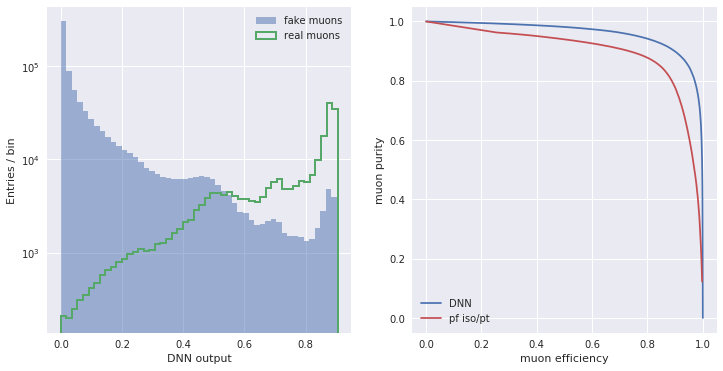

In [28]:
# make some performance plots
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(12,6), facecolor='white')
h1 = axes[0].hist(p_fake, bins=50, histtype='stepfilled', alpha=0.5)
h2 = axes[0].hist(p_real, bins=50, histtype='step', linewidth=2.)
axes[0].set_yscale('log')
axes[0].set_xlabel('DNN output')
axes[0].set_ylabel('Entries / bin')
axes[0].legend(['fake muons', 'real muons'])

axes[1].plot(eff_real, 1. - eff_fake)
axes[1].plot(eff_iso_real, 1 - eff_iso_fake, c='C2')
axes[1].set_xlabel('muon efficiency')
axes[1].set_ylabel('muon purity')
axes[1].legend(['DNN', 'pf iso/pt'])

plt.show()